##  <span style="color:blue">Automatic analysis of Soccer Ball Possessions  </span>

**Submission date: 7.3.2021**


###  <span style="color:blue"> Introduction </span>

In this project, we are trying to measure ball possession of soccer games automatically by classifying which team possesses the ball in each frame, based on computer vision techniques.

Our algorithm divides into 3 main parts:
1. Detect the ball and tracking it
2. Players detection and classification
3. Calculate ball possession in each frame and aggregate it


###  <span style="color:blue"> Technical diagram of our project  </span>

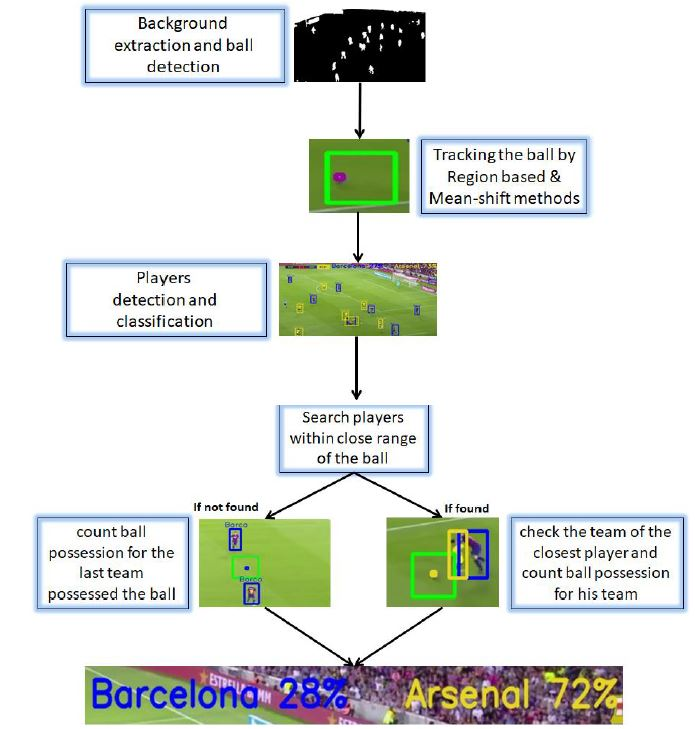

###  <span style="color:blue"> The code  </span>

### Initialization

In [18]:
import cv2
import numpy as np

In [126]:
#Reading video. choose the video you want to run (from the 3 examples below)

# vidcap = cv2.VideoCapture('data/video_1.mp4')
# vidcap = cv2.VideoCapture('data/video_2.mp4')
vidcap = cv2.VideoCapture('data/video_3.mp4')

In [41]:
def save_output(v, out_file_name):
    #save the video into your computer

    #Parameters:
    #    v :the input video
    #    out_file_name :the name of the file that will be saved

    #Returns:
    #    out :the output video
    
    x = np.shape(v)[1]
    y = np.shape(v)[2]

    out = cv2.VideoWriter(out_file_name,
    cv2.VideoWriter_fourcc(*"MJPG"), 30, (y,x))

    for i in range(np.shape(v)[0]):
        out.write(v[i].astype('uint8'))
    print("done!")
    out.release() 

### Different functions for ball tracking using region based 

#### Adaptive window
This function enlarge the seraching window when the ball is not found.
We first start with small window (60X60) and enlarge it until we find the ball or we get to 240X240 window size.
The ball size is 11X11 pixels so 60X60 window track very well mostly when the ball moves slowly. If the ball moves fast it gets out of the next frame so bigger window help tracking in that case. On the other hand we found that large window more occasionally make mistakes and detects different objects, similar to the ball, as the ball.

In [ ]:
def bigger_track_win(track_window, width_img, height_img):
    #enlarge the track window

    #Parameters:
    #    track_window :contain 4 elements - x,y position of left bottom corner, width and height
    #    width_img, height_img :the frame width and height

    #Returns:
    #    new_track_window :the enlarge the track window
    
    #expand the window with 30 pixels for each direction
    x,y,w,h = track_window
    x = x-30
    y = y-30
    w = w+60
    h = h+60
    
    #verify x,y coordinates are in the frame boundries
    if (x<0):
        x=0
    if (y<0):
        y=0
    if (x+w>width_img):
        x=width_img-w
    if (y+h>height_img):
        y=height_img-h

    new_track_window = x,y,w,h
    return new_track_window

The next 3 functions try to optimize the detection of the ball in the tracking window. If ball found, it returns the location of the ball.
Those functions use:
1. Color masking
2. Shape and size analysis
3. Morphological operations

In [ ]:
def get_ball_index(hsv_img, track_window, lower_ball, upper_ball):
    #return all matching pixels to the ball features

    #Parameters:
    #    hsv_img :the frame in hsv colors
    #    track_window :the current track window
    #    lower_ball :the lower values of the ball hsv colors
    #    upper_ball :the upper values of the ball hsv colors
    
    
    #Returns:
    #    idx_ball :the indexes of correlated pixels between the predicted ball colors and the actual values in the tracking window
    
    #tracking window
    x,y,w,h = track_window
    hsv_window = hsv_img[y:y+h, x:x+w]

    #the mask compute only pixels matching the color of the ball
    mask_window = cv2.inRange(hsv_window, lower_ball, upper_ball)    
    mask_window = delete_unfit_contours(mask_window)
    mask_window = corr_ball_pixels(mask_window)
    
    #return all ball indices
    idx_ball = np.nonzero(mask_window)
    return idx_ball

def delete_unfit_contours(mask):
    #delete contours which are not match to the ball shape  

    #Parameters:
    #    mask : binary mask of all correlated pixels between the predicted ball colors and the actual values in the tracking window
    
    #Returns:
    #    mask : new mask of all the input correlated pixels except those which are not match to the ball shape 
    
    #deletes contours that are too small or too large
    contours,hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if (w>10 or w<4):
            mask[y:y+h, x:x+w] = 0 
        if (h>10 or h<4):
            mask[y:y+h, x:x+w] = 0 
        if (h>w+2 or h<w-2):
            mask[y:y+h, x:x+w] = 0 
    
    kernel = np.ones((1,1),np.uint8)
    mask = cv2.erode(mask, kernel, iterations = 1)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    
    #deletes contours that are too small or too large after dilation
    contours,hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if (w>10 or w<4):
            mask[y:y+h, x:x+w] = 0 
        if (h>10 or h<4):
            mask[y:y+h, x:x+w] = 0 
        if (h>w+2 or h<w-2):
            mask[y:y+h, x:x+w] = 0 
            
    return mask

def corr_ball_pixels(mask):
    #find the best correlation of the ball by measuring the number of pixels per contour  

    #Parameters:
    #    mask : binary mask of all correlated pixels between the predicted ball colors and the actual values in the tracking window
    
    #Returns:
    #    mask : new mask of all the new predicted location of the ball (return blank mask if the ball wasn't found)
    
    bestfit_contour_pixels = 0
    xball=-1
    contours,hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        contour_img = mask[y:y+h, x:x+w]
        contour_pixels = cv2.countNonZero(contour_img)
        #check if the predicted ball number of pixels meet the actual number of pixels in the given mask
        if (contour_pixels>bestfit_contour_pixels and contour_pixels>25 and contour_pixels<45):
            #update ball location
            bestfit_contour_pixels = contour_pixels
            xball = x
            yball = y
            wball = w
            hball = h
            
    #if ball found then emphasize ball location for next calculations        
    if (xball>=0):
        mask[yball:yball+hball, xball:xball+wball] = np.where(mask[yball:yball+hball, xball:xball+wball] == 255, 1, 0)
        mask = np.where(mask == 1, 255, 0)
        
    #if ball wasn't found color the mask with zeros
    else:
        mask = np.where(mask < 256, 0, 0)
    return mask

The next function find ball location and update the tracking window to the new location

In [ ]:
def find_ball(idx_ball):   
    #find the ball estimated boundaries

    #Parameters:
    #    idx_ball :the ball pixels
    
    #Returns:
    #    ball_area : the ball estimated boundaries
    
    top_ball = np.min(idx_ball[0])
    bot_ball = np.max(idx_ball[0])
    left_ball = np.min(idx_ball[1])
    right_ball = np.max(idx_ball[1])
    #cv2.rectangle(image,(x+left_ball-3,y+bot_ball-5),(x+right_ball+3,y+top_ball+5),(0,0,255),3)
    ball_area = top_ball, bot_ball, left_ball, right_ball
    return ball_area

def update_track_window(ball_area):
    #resotre the track window to the basic size around the new location of the ball    

    #Parameters:
    #    ball_area :the ball estimated boundaries
    
    #Returns:
    #    new_track_window : track_window around the ball coordinats
    #    x, y :the ball x,y coordinates in the current frame
    
    #find the estimated coordinates of the center of the ball
    top_ball, bot_ball, left_ball, right_ball = ball_area
    x_avg = left_ball+(right_ball-left_ball)/2
    y_avg = bot_ball+(top_ball-bot_ball)/2

    #update track window around the new location of tha ball and restore the window to basic size
    new_track_window = int(x+int(x_avg)-w/(w/30)), int(y+int(y_avg)-h/(h/30)), int(w/(w/60)), int(h/(h/60))
    
    new_track_window = list(new_track_window)
    
    #verify x,y coordinates are in the frame boundries
    if(new_track_window[0]<0):
        new_track_window[0] = 0
    if(new_track_window[1]<0):
        new_track_window[1] = 0
    
    return new_track_window, x+int(x_avg), y+int(y_avg)

def update_track_window_all_img(ball_area):
    #restore the track window to the basic size after searching in whole image (we use it in cases ball isn't found for more than 1 second)    

    #Parameters:
    #    ball_area :the ball estimated boundaries
    
    #Returns:
    #    new_track_window : track_window around the ball coordinats
    #    x, y :the ball x,y coordinates in the current frame
    
    #find the estimated coordinates of the center of the ball
    top_ball, bot_ball, left_ball, right_ball = ball_area
    x_avg = left_ball+(right_ball-left_ball)/2
    y_avg = bot_ball+(top_ball-bot_ball)/2
    w=60
    h=60
    
    #update track window to the new location of tha ball and restore the window to basic size
    new_track_window = int(x_avg)-w, int(y_avg)-h, w, h
    
    new_track_window = list(new_track_window)
    
    #verify x,y coordinates are in the frame boundries
    if(new_track_window[0]<0):
        new_track_window[0] = 0
    if(new_track_window[1]<0):
        new_track_window[1] = 0
    
    return new_track_window, int(x_avg), int(y_avg)

Function for players detection:

In [127]:
def count_pixels_object(contour_img, contour_hsv, lower_col, upper_col):
    #return the number of pixels which match the color range

    #Parameters:
    #    hsv_img :the given contour in RGB color
    #    contour_hsv :the given contour in hsv color
    #    lower_col :the lower values of the object hsv colors
    #    upper_col :the upper values of the object hsv colors
    
    #Returns:
    #    count_pixels :number of pixels which match the color range of the given object
    #    res : gray image of the object
    
    mask = cv2.inRange(contour_hsv, lower_col, upper_col)
    res = cv2.bitwise_and(contour_img, contour_img, mask=mask)
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    res = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    count_pixels = cv2.countNonZero(res)
    return count_pixels, res


### Main code 

Select the first ball location from the relevant video<br>
The first location already found manually by observing the first frame in each one of the given videos below

In [128]:
#first location for 'video_1' 
# x,y,w,h = 593, 511, 60, 60 

#first location for 'video_2'
# x,y,w,h = 174, 446, 60, 60 

#first location for 'video_3'
x,y,w,h = 854, 615,60,60 

Initializations before processing the video:

In our videos:
1. Barcelona = Team 1
2. Arsenal = Team 2

In [121]:
success,image = vidcap.read()
count = 0 #count number of frames
success = True
movie = [] #array contain all frames after processing
font = cv2.FONT_HERSHEY_SIMPLEX #text font

width_img = int(image.shape[1])
height_img = int(image.shape[0])

#read the video first frame to get the exact location of the ball
#the x,y coordinates should be calculated manually
"""
if count == 0:
    cv2.imwrite("frame%d.jpg" %count, image)    
    success,image = vidcap.read()
"""

track_window = x,y,w,h #initialization of the track window 

all_img_track_window = 0,0,width_img,height_img #initialization of track window searching in the whole image
all_img_detect = False #flag for indicate if the ball got detected with whole image window or not

#initialization of the lower and upper values of the teams,ball and grass (in hsv colors)
#grass range
lower_green = np.array([40,40, 40])
upper_green = np.array([70, 255, 255])

#barca (team1) range
lower_team1 = np.array([110,50,100])
upper_team1 = np.array([140,235,170])

#arsenal (team2) range
lower_team2 = np.array([25,210,190])
upper_team2 = np.array([45,255,255])

#ball range
lower_ball = np.array([40,20,190])
upper_ball = np.array([110,110,255])
  
timer=0 #count consecutive frames in which the ball is not detected

#initial variables for computing the team which possesses the ball
x_ball = int(width_img/2)
y_ball = int(height_img/2)
is_contact_team1 = False #flag which indicate if team 1 posses the ball in the current frame
is_contact_team2 = False #flag which indicate if team 2 posses the ball in the current frame
contact_range = 1 #number of search layers around ball (number of pixels in each direction)
last_team1 = False #flag which indicate if team 1 was the last team that possesed the ball 
last_team2 = False #flag which indicate if team 2 was the last team that possesed the ball 
count_team1_pos = 0 #count number of frames team 1 possesed the ball
count_team2_pos = 0 #count number of frames team 2 possesed the ball
count_total_pos = 0 #count number of frames that team 1 or team 2 possesed the ball
total=100

In [122]:
#read frame by frame 
while success and count<=700:
    
    "Part 1 - Ball detection and tracking"
    
    #transform frame to hsv colors
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #search and get ball indexes
    idx_ball = get_ball_index(hsv_img, track_window, lower_ball, upper_ball)
    
    #if the ball is not detected then iterate with larger window until it reach the given limit
    while ((len(idx_ball[0]) < 5) and (w<=180)):
        track_window = bigger_track_win(track_window, width_img, height_img) #create bigger track window
        x,y,w,h = track_window
        idx_ball = get_ball_index(hsv_img, track_window, lower_ball, upper_ball) #seach and get ball indexes
                   
    #if past 1 second since last ball detection then search in all image to expand searching
    if (timer >= 30):
    #if (timer >= 30 or count%30 == 0): #use this condition for search all frame once in a second
        idx_ball = get_ball_index(hsv_img, all_img_track_window, lower_ball, upper_ball)
        all_img_detect = True
        
    #if the ball got detected mark the ball (rectangle around the ball) and update track window
    if (len(idx_ball[0]) >= 5):
        ball_area = find_ball(idx_ball)
        
        #print bounding box of tracking area
        box = cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0),3) 
        
        #check if the ball got detected by the all image window
        #in each cases update the tracking window to the new location and restore the window to the basic size
        if (all_img_detect == True):
            track_window, x_ball, y_ball = update_track_window_all_img(ball_area)
            all_img_detect = False
        else:
            track_window, x_ball, y_ball = update_track_window(ball_area)
        x,y,w,h = track_window
        timer = 0
    else:
        #count time since last ball detection
        timer = timer+1
     
    "Part 2 - Players detection and classification"
    
    #copy of the original image for coloring the area of the detecting players      
    color_player_image = image.copy()   
     
    #define a mask for background ranging from lower to uppper
    mask_background = cv2.inRange(hsv_img, lower_green, upper_green)
    res = cv2.bitwise_and(image, image, mask=mask_background)
    
    #convert back hsv to gray
    res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)

    #defining a kernel to do morphological operation in threshold image to get better output
    kernel = np.ones((3,3),np.uint8)
    thresh1 = cv2.threshold(res_gray,127,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh2 = cv2.erode(thresh1, kernel, iterations = 1)
    thresh3 = cv2.dilate(thresh2, kernel, iterations = 2)
     
    #use this code for using k-means + switch line below, which begin with "player_img"
    """ 
    new_image = image.copy()
    new_image[thresh3==0] = 0
    new_image_hsv = cv2.cvtColor(new_image,cv2.COLOR_BGR2HSV)
    
    color_hist = new_image_hsv.reshape((-1,3))
    
    # convert to np.float32
    color_hist = np.float32(color_hist)
    
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 15
    ret,label,center=cv2.kmeans(color_hist,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    means_img = center[label.flatten()]
    means_img = means_img.reshape((new_image_hsv.shape))
    
    #barca range hsv
    lower_team1 = np.array([60,50,135])
    upper_team1 = np.array([125,155,195])

    #arsenal range hsv
    lower_team2 = np.array([20,205,205])
    upper_team2 = np.array([40,230,225])
    """
    
    #find contours in threshold image     
    contours,hierarchy = cv2.findContours(thresh3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        #get contour coordiates
        x_con,y_con,w_con,h_con = cv2.boundingRect(c)        

        #detect players by contour size range
        if(w_con>10 and h_con>20 and w_con<120 and h_con<120):
            
            #create matrix of the player contour
            player_img = image[y_con:y_con+h_con,x_con:x_con+w_con] #switch when not using k-means
#             player_img = means_img[y_con:y_con+h_con,x_con:x_con+w_con] #switch when using k-means
            
            player_hsv = cv2.cvtColor(player_img,cv2.COLOR_BGR2HSV)
            
            #detect players that have team1 jersy
            count_team1_pix, player_area1 = count_pixels_object(player_img, player_hsv, lower_team1, upper_team1)
            
            #detect players that have team2 jersy
            count_team2_pix, player_area2 = count_pixels_object(player_img, player_hsv, lower_team2, upper_team2)
            
            #deal with occlusion between the two teams (two players from different teams that are close to each other)             
            if (count_team1_pix >= 40 and count_team2_pix>=40):
                
                #compute the specific box area around team1
                idx1 = np.nonzero(player_area1)
                top1 = np.min(idx1[0])
                bot1 = np.max(idx1[0])
                left1 = np.min(idx1[1])
                right1 = np.max(idx1[1])
                cv2.rectangle(image,(x_con+left1-5,y_con),(x_con+right1+5,y_con+h_con),(255,0,0),3) 
                color_player_image[y_con:y_con+h_con,x_con+left1-5:x_con+right1+5] = [30,215,230]

                #compute the specific box area around team2
                idx2 = np.nonzero(player_area2)
                top2 = np.min(idx2[0])
                bot2 = np.max(idx2[0])
                left2 = np.min(idx2[1])
                right2 = np.max(idx2[1])
                cv2.rectangle(image,(x_con+left2-5,y_con),(x_con+right2+5,y_con+h_con),(30,215,230),3) 
                color_player_image[y_con:y_con+h_con,x_con+left2-5:x_con+right2+5] = [30,215,230]
                            
            #mark players as team1
            elif (count_team1_pix>=20):
                cv2.putText(image, 'Barca', (x_con-12, y_con-6), font, 0.6, (255,0,0), 1, cv2.LINE_AA)
                cv2.rectangle(image,(x_con,y_con),(x_con+w_con,y_con+h_con),(255,0,0),3) 
                color_player_image[y_con:y_con+h_con,x_con:x_con+w_con] = [255,0,0]
                              
            #mark players as team2
            elif (count_team2_pix>=20):
                cv2.putText(image, 'Arsenal', (x_con-17, y_con-6), font, 0.6, (30,215,230), 1, cv2.LINE_AA)
                cv2.rectangle(image,(x_con,y_con),(x_con+w_con,y_con+h_con),(30,215,230),3)
                color_player_image[y_con:y_con+h_con,x_con:x_con+w_con] = [30,215,230]
    
    "Part 3 - Calculate ball possession in each frame and aggregate it"

    #compute if the possession pass from one team to another
    while (is_contact_team1 == False and is_contact_team2 == False and contact_range<=20):
        contact_area = color_player_image[y_ball-contact_range:y_ball+contact_range+1,x_ball-contact_range:x_ball+contact_range+1]
        for i in range (contact_area.shape[0]):
            for j in range (contact_area.shape[1]):
                if (contact_area[i,j,0] == 255 and contact_area[i,j,1] == 0 and contact_area[i,j,2] == 0):
                    is_contact_team1 = True
                    last_team1 = True
                    last_team2 = False
                    break
                if (contact_area[i,j,0] == 30 and contact_area[i,j,1] == 215 and contact_area[i,j,2] == 230):
                    is_contact_team2 = True
                    last_team1 = False
                    last_team2 = True
                    break
        contact_range += 1
    
    is_contact_team1 = False
    is_contact_team2 = False
    contact_range = 1
    
    #check if no team posses the ball or past 3 seconds without the ball being detected
    if ((last_team1 == False and last_team2 == False) or timer>90):
        cv2.rectangle(image,(x_ball-3,y_ball-3),(x_ball+3,y_ball+3),(153,0,153),3) #purple ball color for no team possesion
        is_contact_team1 = False
        is_contact_team2 = False

    #check if team1 possesses the ball
    elif (last_team1 == True and last_team2 == False):
        #show ball only if detected in this frame
        if (len(idx_ball[0]) >= 5):
            cv2.rectangle(image,(x_ball-3,y_ball-3),(x_ball+3,y_ball+3),(255,0,0),3) #blue ball color for team 1 possesions
        count_team1_pos +=1
        count_total_pos +=1
        
    #check if team2 possesses the ball
    elif (last_team1 == False and last_team2 == True):
        #show ball only if detected in this frame
        if (len(idx_ball[0]) >= 5):
            cv2.rectangle(image,(x_ball-3,y_ball-3),(x_ball+3,y_ball+3),(30,215,230),3) #yellow ball color for team 1 possesions
        count_team2_pos +=1
        count_total_pos +=1
    
    #compute ball possession of each team and show it
    if (count_total_pos>0):
        team1_pos = int(count_team1_pos/count_total_pos*100)
        precentage_team1 = str(team1_pos)
        precentage_team2 = str(100-team1_pos)  
        cv2.putText(image, 'Barcelona '+precentage_team1+'%', (420, 60), font, 1.5, (255,0,0), 3, cv2.LINE_AA)
        cv2.putText(image, 'Arsenal '+precentage_team2+'%', (850, 60), font, 1.5, (30,215,230), 3, cv2.LINE_AA)

    count += 1   
    
    movie.append(image)    
    success,image = vidcap.read()


vidcap.release()
cv2.destroyAllWindows()
save_output(movie, 'results/vid3-result-alg1.avi')    

done!


#### Notes regarding ball tracking:
<br>Ball color is purple: no team possesion
<br>Ball color is blue: team1 possesion
<br>Ball color is red: team2 possesion

###  <span style="color:blue"> Examples of results, further explanations and future works  </span>

#### Example of final results 

In [38]:
from IPython.display import YouTubeVideo

YouTubeVideo('LOQMCiAzLGQ', width=800, height=300)

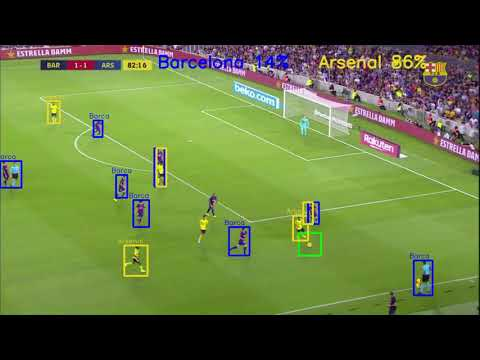

In [39]:
from IPython.display import YouTubeVideo

YouTubeVideo('H7t3cTqFSf8', width=800, height=300)

#### Uses of K-means

In this project we tried to use K-means for better players detection.
We used 3 different approaches:
1. K-means per every contour - helped differentiate between teams but sometimes make flase detection since it very influnced by the objects inside the contour (like if the contour doesn't include the player shoes or include another player it gives totally different set of colors for the same player with shoes). example: 

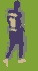

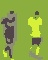

2. K-means per the all frame - Test it with k=10/15 different colors. Indeed we got slightly better result but it cost a lot of time complexity so we dicided leave that as a comment in our code. example:



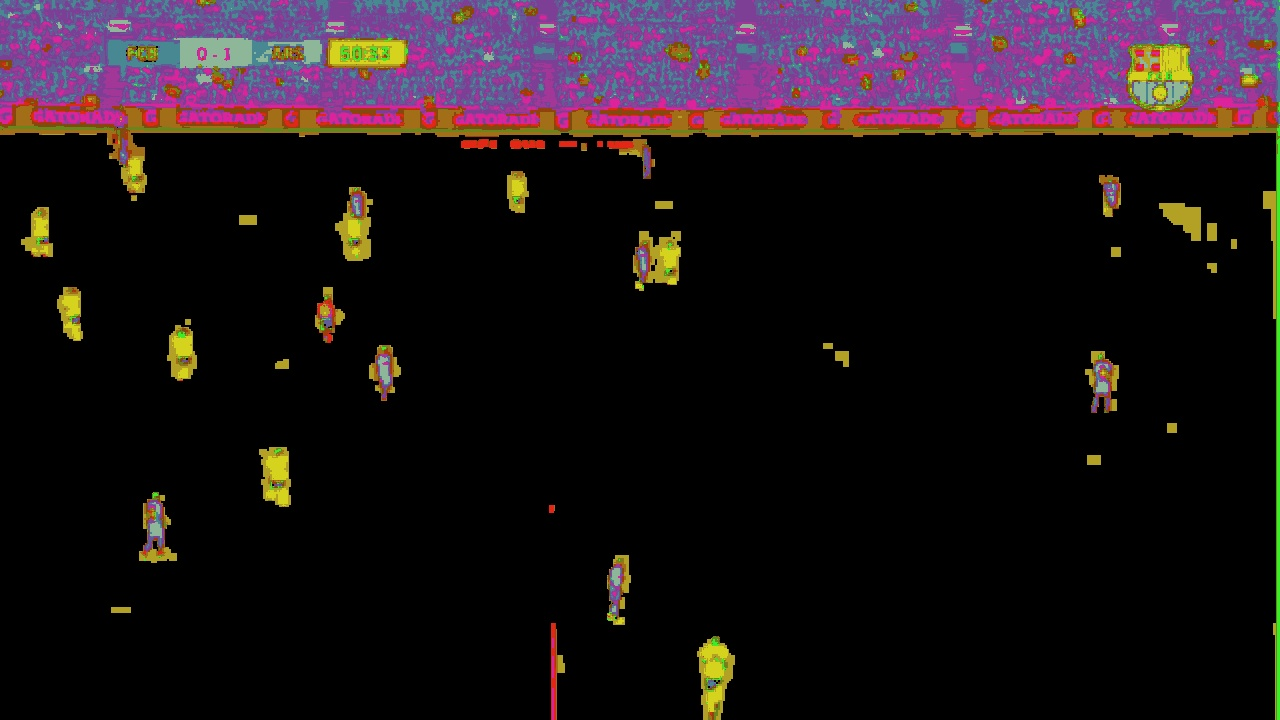









#### Object detection

We detected the players and the ball mostly based on the their color and their shapes.
That segregation worked well and is robust to noise, illuminations, distance from camera and more, but could be improved by using color and gradients histograms to better identifying the players of each team (update histograms every k frames)

Good example of object detection:

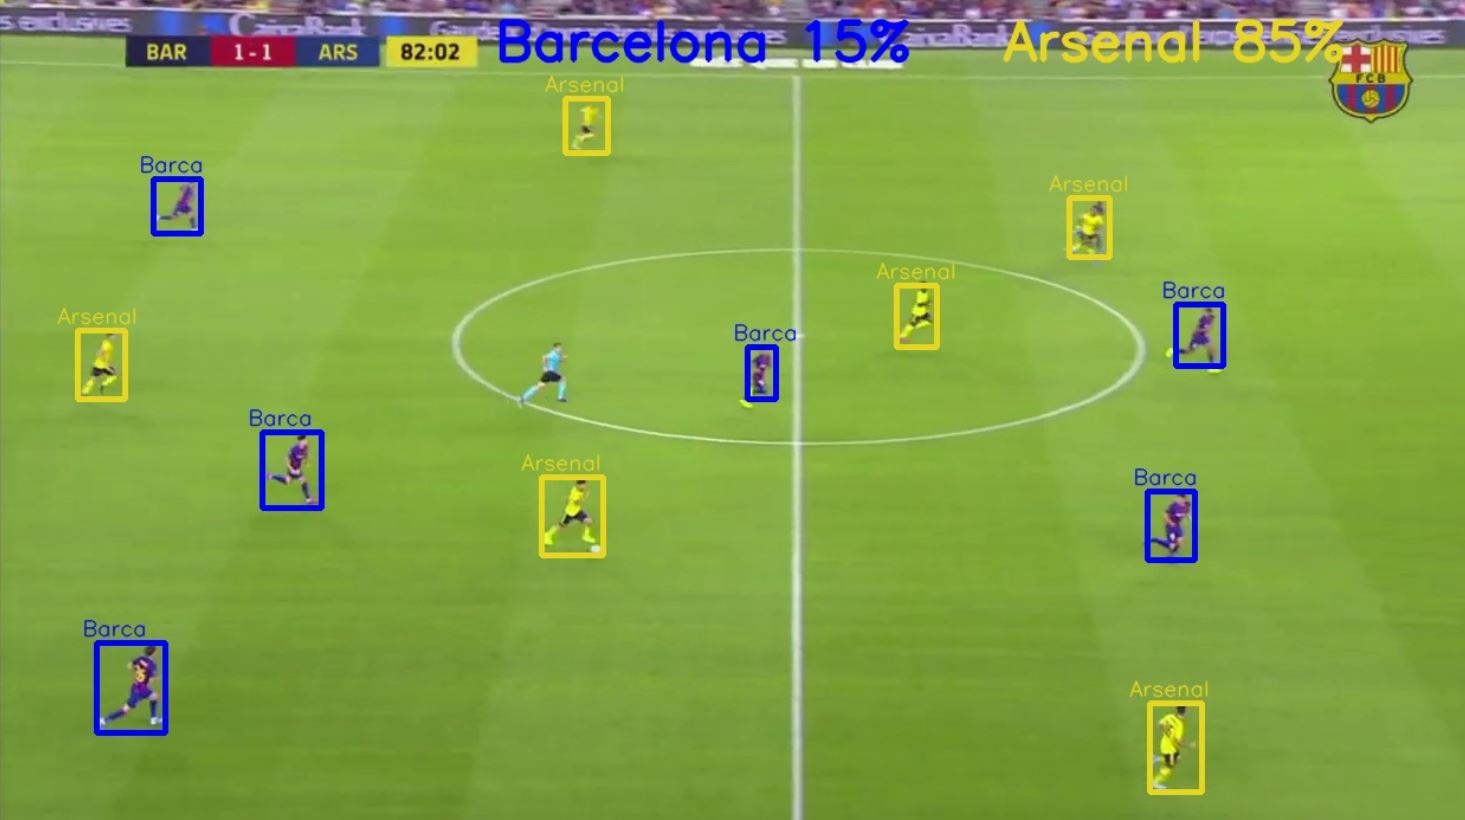

Bad example  of object detection:
1. Arsenal player (bottom right corner) is not recognized since Barca player hide him and there is not enough yellow pixels to identification 
2. The referee is in the same contour with Barca player and also counted as Barca player

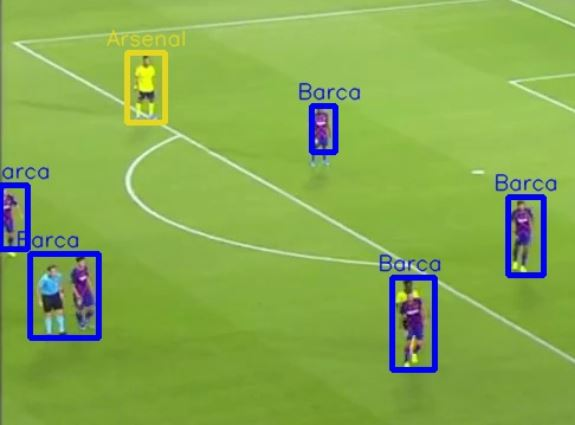

#### Deal with occlussion of players

Sometimes in the match players hide each other. Since we used one single camera it's a challenge to identify each player and decide which teams he belongs. 
We tried to deal with that problem by:
1. Measuring pixels with colors of both teams in the same contour (above some threshold).
2. Sorting the pixels in that contour into two groups
3. Locating the main area of each group of pixels and present that areas as the players
*This method worked well for 2 players max in the same contour. We didn't deal with more than that Since those cases are rare and doesn’t have much importance in our program.

Good example of dealing with occlusion:

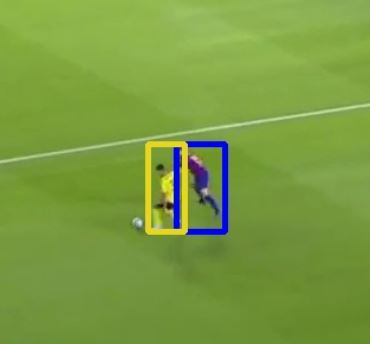

Bad example  of dealing with occlusion (more than 2 players in the same contour):

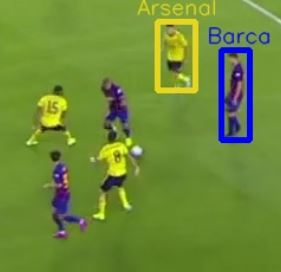

#### Region based and Mean-Shift with adaptive tracking window:
Using adaptive window help in cases the ball is moving too fast for small searching window.
Deep analysis of the ball features enable nice results on some videos but we found it very challenging to avoid false detection of areas similar to the shape and the color of the ball (like the center circle of the field). 

Good example of region based:
Yellow ball means it's Arsenal possession,
Green rectangle is the tracking window

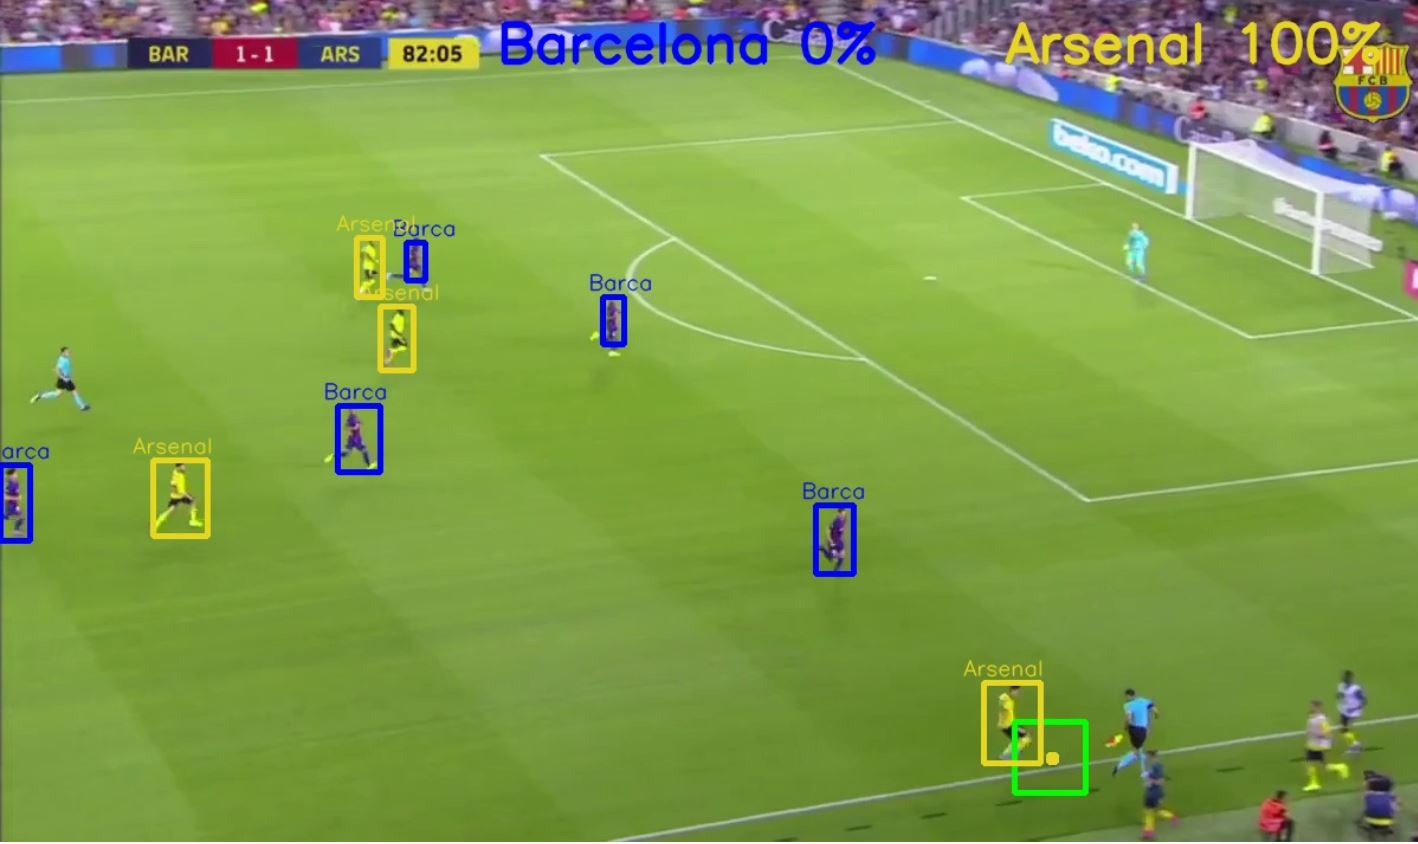

Bad example of region based:<br>
The detection falsely identify the player shoe as the ball, and start tracking it

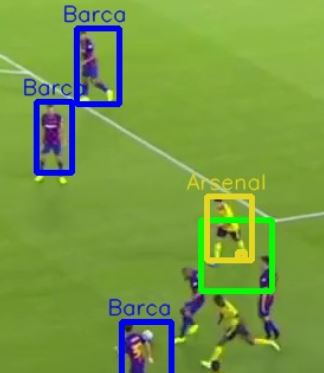

#### Kalman Filter:
We tried Kalman Filter which sometimes gave better result from region based but most of the time failed since he motion model of the ball is inconsistent and changes frequently

Good example of Kalman Filter prediction:<br>3 frames in a row and KF succeeded to predict ball location behind the player

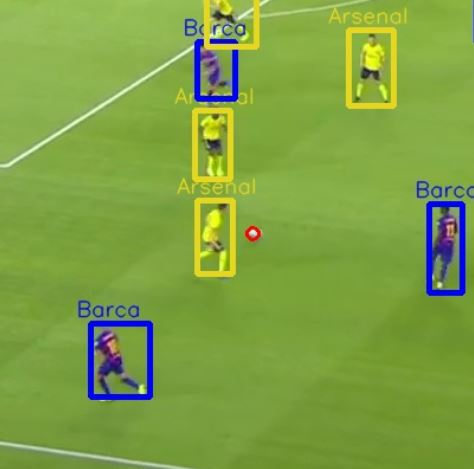

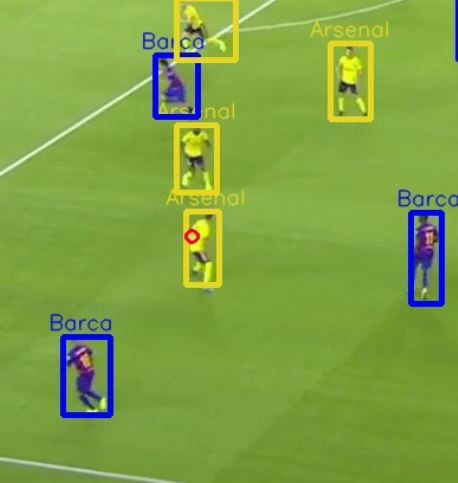

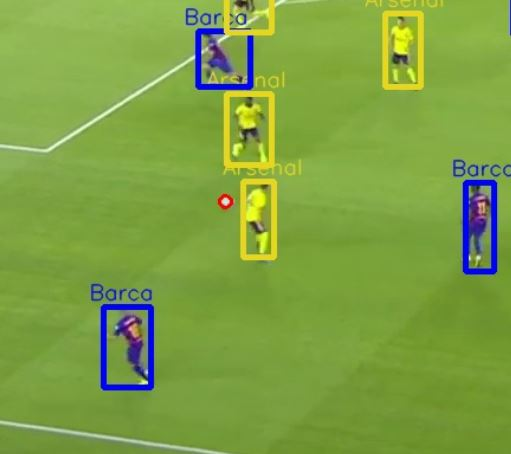

Bad example  of Kalman Filter: <br>prediction didn't track well on the ball movement

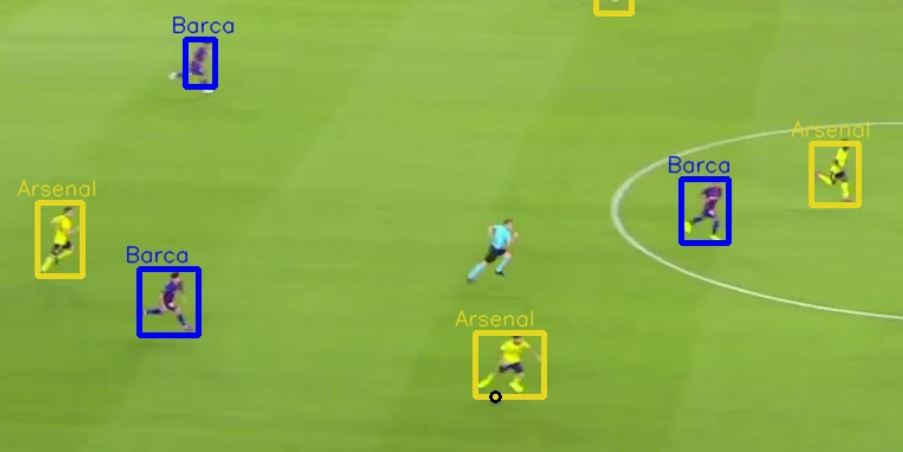

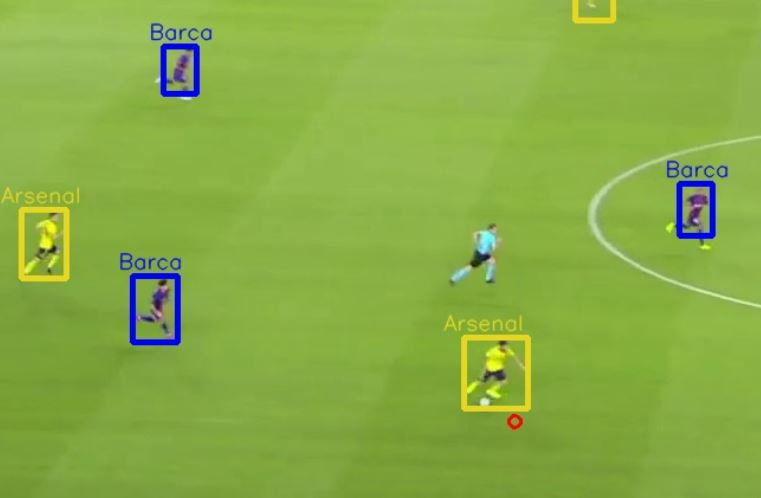